<a href="https://colab.research.google.com/github/ajmd2/Jinling-Enlightenment/blob/main/rl/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [ ]:
class PPOMemory:
  def __init__(self,batch_size):
    self.states = []
    self.probs = []
    self.vals = []
    self.actions = []
    self.rewards = []
    self.dones = []

    self.batch_size = batch_size

  def generate_batches(self):
    n_states = len(self.states)
    batch_start = np.arange(0,n_states,self.batch_size)
    indices = np.arange(n_states,dtype=np.int64)
    np.random.shuffle(indices)
    batches  = [indices[i:i+self.batch_size] for i in batch_start]

    return np.array(self.states),np.array(self.actions),np.array(self.probs),np.array(self.vals),np.array(self.rewards),np.array(self.dones),batches

    # np不算梯度，tensor算梯度



  def store_memory(self,state,action,probs,vals, reward, done):
    #print(f"Storing: state={state}, action={action}, probs={probs}, vals={vals}, reward={reward}, done={done}")
    self.states.append(state)
    self.actions.append(action)
    self.probs.append(probs)
    self.vals.append(vals)
    self.rewards.append(reward)
    self.dones.append(done)
    #print(f"Current memory size: {len(self.states)}")

  def clear_memory(self):
    self.states = []
    self.probs = []
    self.actions = []
    self.vals = []
    self.reward = []
    self.dones = []


In [ ]:
import os
class ActorNetwork(nn.Module):
  def __init__(self,n_actions,input_dims,alpha,fc1_dims=256,fc2_dims=256,chkpt_dir=None):
    super(ActorNetwork,self).__init__()

    if chkpt_dir is None:
      chkpt_dir = os.getcwd()

    self.checkpoint_file = os.path.join(chkpt_dir,'actor_torch_ppo')
    self.actor = nn.Sequential(
            nn.Linear(*input_dims,fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims,fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims,n_actions),
            nn.Softmax(dim=-1)
    )

    self.optimizer = optim.Adam(self.parameters(),lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)


  def forward(self,state):
    dist = self.actor(state)
    dist = Categorical(dist)

    return dist

  #   # 定义一个动作的概率分布
  # probs = torch.tensor([0.1, 0.3, 0.4, 0.2])  # 假设有四个动作的概率
  # dist = Categorical(probs)  # 创建一个类别分布对象

  # # 从分布中采样一个动作
  # sampled_action = dist.sample()
  # print("Sampled action:", sampled_action.item())

  def save_checkpoint(self):
    T.save(self.state_dict(),self.checkpoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))


class CriticNetwork(nn.Module):
  def __init__(self,input_dims,alpha,fc1_dims=256,fc2_dims=256,chkpt_dir=None):
    super(CriticNetwork,self).__init__()
    # 如果未指定路径，默认为当前工作目录
    if chkpt_dir is None:
        chkpt_dir = os.getcwd()  # 获取 Colab 当前工作目录

    self.checkpoint_file = os.path.join(chkpt_dir,'critic_torch_ppo')
    self.critic = nn.Sequential(
            nn.Linear(*input_dims,fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims,fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims,1)
    )

    self.optimizer = optim.Adam(self.parameters(),lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)


  def forward(self,state):
    value = self.critic(state)

    return value

  def save_checkpoint(self):
    T.save(self.state_dict(),self.checkpoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))



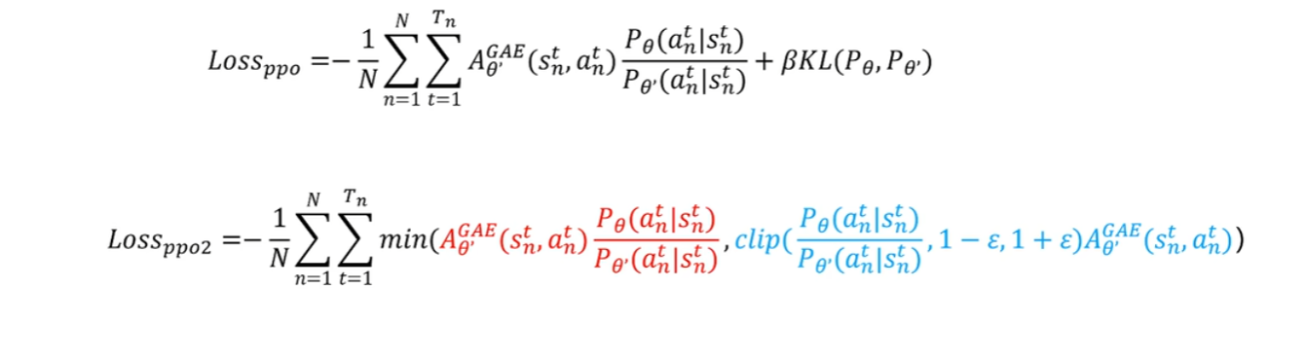

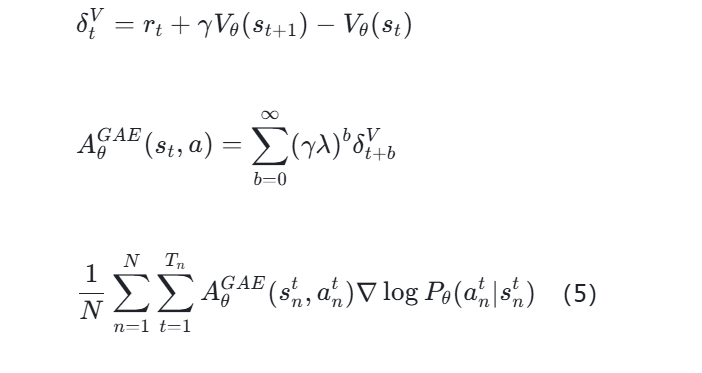

In [ ]:
class Agent:
  def __init__(self,n_actions,input_dims,gamma=0.99,alpha=0.0003,gae_lambda=0.95,policy_clip=0.2,batch_size=64,N=2048,n_epochs=10):
    self.gamma = gamma
    self.policy_clip = policy_clip
    self.n_epochs = n_epochs
    self.gae_lambda = gae_lambda

    self.actor = ActorNetwork(n_actions, input_dims, alpha) # alpha = lr
    self.critic = CriticNetwork(input_dims, alpha)
    self.memory = PPOMemory(batch_size)


  def remember(self, state, action, probs, vals, rewards, done):
    self.memory.store_memory(state,action,probs,vals,reward,done)

  def save_models(self):
    print('...saving model ..')
    self.actor.save_checkpoint()
    self.critic.save_checkpoint()


  def load_models(self):
    print('...loading model ..')
    self.actor.load_checkpoint()
    self.critic.load_checkpoint()

  def choose_action(self,obseravtion):
    state = T.tensor([observation],dtype=T.float).to(self.actor.device)

    dist = self.actor(state)
    value = self.critic(state)
    action = dist.sample()

    probs = T.squeeze(dist.log_prob(action)).item() #  移除张量中维度为 1 的部分 item 转换成标量
    action = T.squeeze(action).item()
    value = T.squeeze(value).item()

    return action, probs, value

  def learn(self):
    for _ in range(self.n_epochs):
      state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()


      values = vals_arr
      advantage = np.zeros(len(reward_arr),dtype=np.float32) # gae init

      for t in range(len(reward_arr)-1):
        discount = 1
        a_t = 0
        for k in range(t,len(reward_arr)-1):
          if k + 1 >= len(values):  # 检查是否超界
            break
          a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k]))-values[k]) # 这里对的就是最重要的gae公式的表达
          discount *=self.gamma*self.gae_lambda
        advantage[t] = a_t
      advantage = T.tensor(advantage).to(self.actor.device)

      values = T.tensor(values).to(self.actor.device)
      for batch in batches:
        states = T.tensor(state_arr[batch],dtype=T.float).to(self.actor.device)
        old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
        actions = T.tensor(action_arr[batch]).to(self.actor.device)

        dist = self.actor(states)
        critic_value = self.critic(states)
        critic_value = T.squeeze(critic_value)

        new_probs = dist.log_prob(actions)
        prob_ratio = new_probs.exp() / old_probs.exp()

        weighted_probs = advantage[batch]*prob_ratio
        weighted_clipped_probs = T.clamp(prob_ratio,1-self.policy_clip,1+self.policy_clip)*advantage[batch]

        actor_loss = -T.min(weighted_probs,weighted_clipped_probs).mean()

        returns = advantage[batch]+values[batch] # 这里在做critic 的ground_truth 也就是V，
        critic_loss = (returns-critic_value)**2
        critic_loss = critic_loss.mean()

        total_loss = actor_loss + 0.5*critic_loss
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()
      self.memory.clear_memory()





In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(x, scores, figure_file):
    """
    绘制学习曲线，将训练过程中分数的变化保存为图片文件。

    参数:
    - x: 横轴的点，通常为 episode 数。
    - scores: 每个 episode 的得分列表。
    - figure_file: 保存图片的文件路径。
    """
    # 计算平均分数（滑动窗口平均）
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])  # 最近 100 个得分的平均值

    # 创建图表
    plt.plot(x, scores, label='Scores')                # 绘制原始得分
    plt.plot(x, running_avg, label='Running Average')  # 绘制滑动平均
    plt.xlabel('Episode')                              # 横轴标题
    plt.ylabel('Score')                                # 纵轴标题
    plt.title('Learning Curve')                        # 图表标题
    plt.legend()                                       # 显示图例
    plt.savefig(figure_file)                           # 保存图片
    plt.close()                                        # 关闭图表


In [ ]:
import gym
import numpy as np


env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
              alpha =alpha, n_epochs=n_epochs,
              input_dims=env.observation_space.shape)
n_games = 300
figure_file = 'cartpole.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
  observation = env.reset()
  done = False
  score = 0
  while not done:
      action, prob, val = agent.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      n_steps += 1
      score += reward
      agent.remember(observation, action, prob, val, reward, done)
      if n_steps % N == 0:
        agent.learn()
        learn_iters +=1
      observation = observation_
  score_history.append(score)
  avg_score = np.mean(score_history[-100:])

  if avg_score > best_score:
      best_score = avg_score
      agent.save_models()

  print('episode',i,'score %1.f' % score, 'avg score %.1f' % avg_score,
      'time_steps',n_steps, 'learning_steps',learn_iters)
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)

...saving model ..
episode 0 score 23 avg score 23.0 time_steps 23 learning_steps 1
episode 1 score 17 avg score 20.0 time_steps 40 learning_steps 2
...saving model ..
episode 2 score 31 avg score 23.7 time_steps 71 learning_steps 3
episode 3 score 19 avg score 22.5 time_steps 90 learning_steps 4
...saving model ..
episode 4 score 48 avg score 27.6 time_steps 138 learning_steps 6
episode 5 score 26 avg score 27.3 time_steps 164 learning_steps 8
...saving model ..
episode 6 score 57 avg score 31.6 time_steps 221 learning_steps 11
episode 7 score 19 avg score 30.0 time_steps 240 learning_steps 12
...saving model ..
episode 8 score 53 avg score 32.6 time_steps 293 learning_steps 14
episode 9 score 30 avg score 32.3 time_steps 323 learning_steps 16
episode 10 score 18 avg score 31.0 time_steps 341 learning_steps 17
episode 11 score 14 avg score 29.6 time_steps 355 learning_steps 17
episode 12 score 64 avg score 32.2 time_steps 419 learning_steps 20
episode 13 score 11 avg score 30.7 time_s